# Online Shoppers Intention (Data set from UCI machine learning repository)
- Build a classification model to predict shoppers intention 
- Steps
    - EDA: Explore the data set
    - Feature Engineering
    - Model Building
    - Model Validation

In [49]:
## import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_fscore_support,roc_curve,roc_auc_score,roc_curve,precision_recall_curve,auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer
import mlflow
plt.style.use('fivethirtyeight')


## Data Set Information:

- The dataset consists of feature vectors belonging to 12,330 sessions.
- Each session belongs to a different user 
- There are 10 numerical features and 8 categorical features
- Revenue Column (Bool Type ). This feature represents if the user completed the purchase or not. ```This is what we we will try to predict ```

In [50]:
df_shopping_data = pd.read_csv('online_shoppers_intention.csv')
print('Number of rows in date set',df_shopping_data.shape)
display(df_shopping_data.head(n=2))
display(df_shopping_data.dtypes)

Number of rows in date set (12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False


Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

## EDA

### No Null Values across columns
- No imputation or dropping of data needed

In [51]:
## EDA
print('Number of null values across columns \n',df_shopping_data.isna().sum())

Number of null values across columns 
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


### Number of Buyers who completed a purchase VS not complete
- This is a highly imbalance set
- In general this would make sense as percentage of buyers who complete a transaction woule be less.

In [52]:
df_shopping_data.Revenue.value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

### Web session related features
#### Number of Pages
- Administrative 
- Informational
- ProductRelated

#### Duration
- Administrative_Duration
- Informational_Duration
- ProductRelated_Duration

We see distinct patterns between Revenue (0 Vs 1).

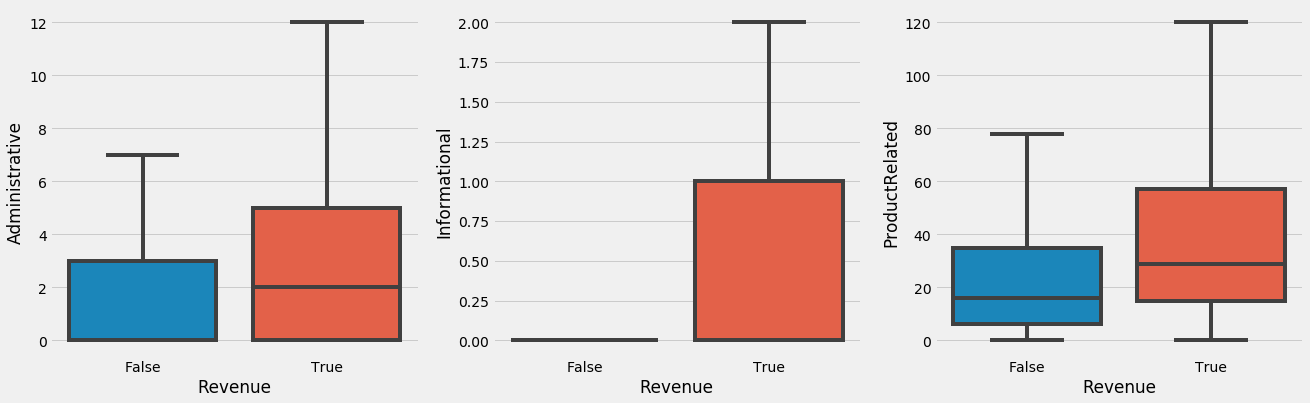

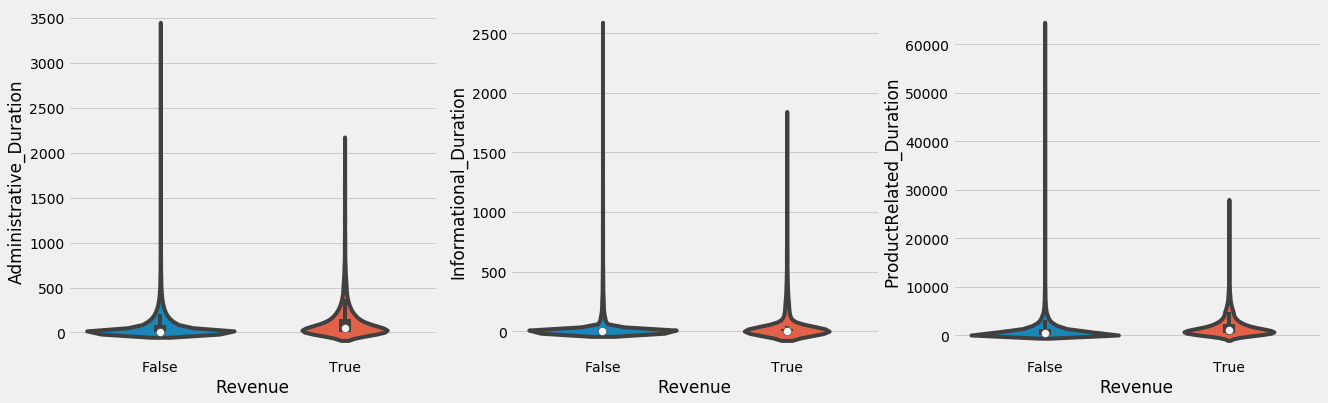

In [53]:

fig, axs = plt.subplots(1,3,figsize=(20,6))

sns.boxplot(y= 'Administrative',x= 'Revenue',ax=axs[0],data=df_shopping_data,showfliers=False)
sns.boxplot(y= 'Informational',x= 'Revenue',ax=axs[1],data=df_shopping_data,showfliers=False)
sns.boxplot(y= 'ProductRelated',x= 'Revenue',ax=axs[2],data=df_shopping_data,showfliers=False)



fig, axs = plt.subplots(1,3,figsize=(20,6))

sns.violinplot(y= 'Administrative_Duration',x= 'Revenue',ax=axs[0],data=df_shopping_data,showfliers=False)
sns.violinplot(y= 'Informational_Duration',x= 'Revenue',ax=axs[1],data=df_shopping_data,showfliers=False)
sns.violinplot(y= 'ProductRelated_Duration',x= 'Revenue',ax=axs[2],data=df_shopping_data,showfliers=False)

### Explore the standard digital metrics
- BounceRates: The percentage of visitors who enter the website through that page and exit without triggering any additional tasks.
- ExitRates: The percentage of pageviews on the website that end at that specific page.
- PageValues: Average value of a page
- Drop the PageValues feature (Outliers present)

<Figure size 432x288 with 0 Axes>

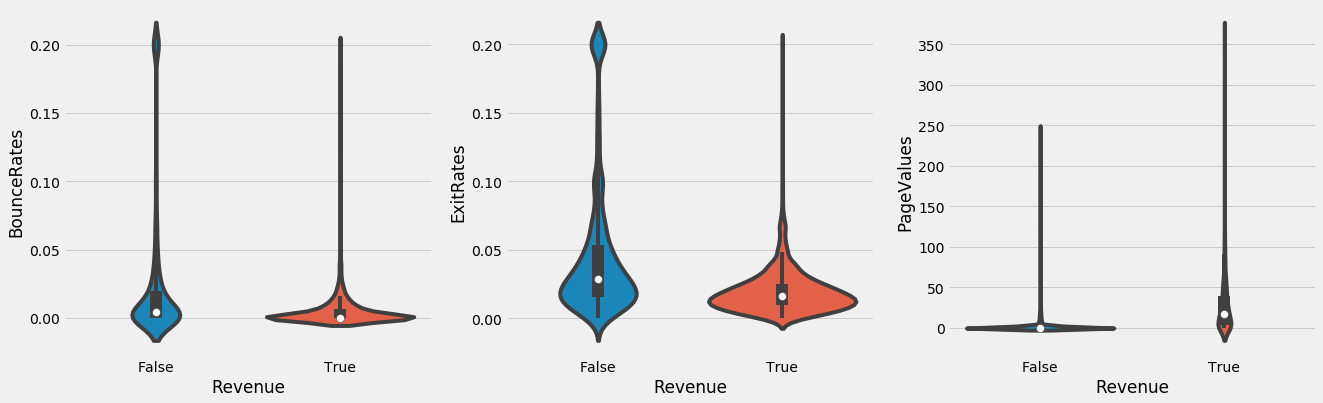

In [54]:
plt.clf()
fig, axs = plt.subplots(1,3,figsize=(20,6))

sns.violinplot(y= 'BounceRates',x= 'Revenue',ax=axs[0],data=df_shopping_data)
sns.violinplot(y= 'ExitRates',x= 'Revenue',ax=axs[1],data=df_shopping_data,showfliers=False)
sns.violinplot(y= 'PageValues',x= 'Revenue',ax=axs[2],data=df_shopping_data,showfliers=False)

#df_shopping_data.loc[:,['BounceRates','ExitRates','PageValues']].describe()

### Explore time related features
- SpecialDay: represents the closeness of the browsing date to special days
- Weekend: A boolean representing whether the session is on a weekend.
- Month: Contains the month the pageview occurred, in string form.
- We notice not all 12 months are present. Missing (Jan,Apr). Hence we will exlude it

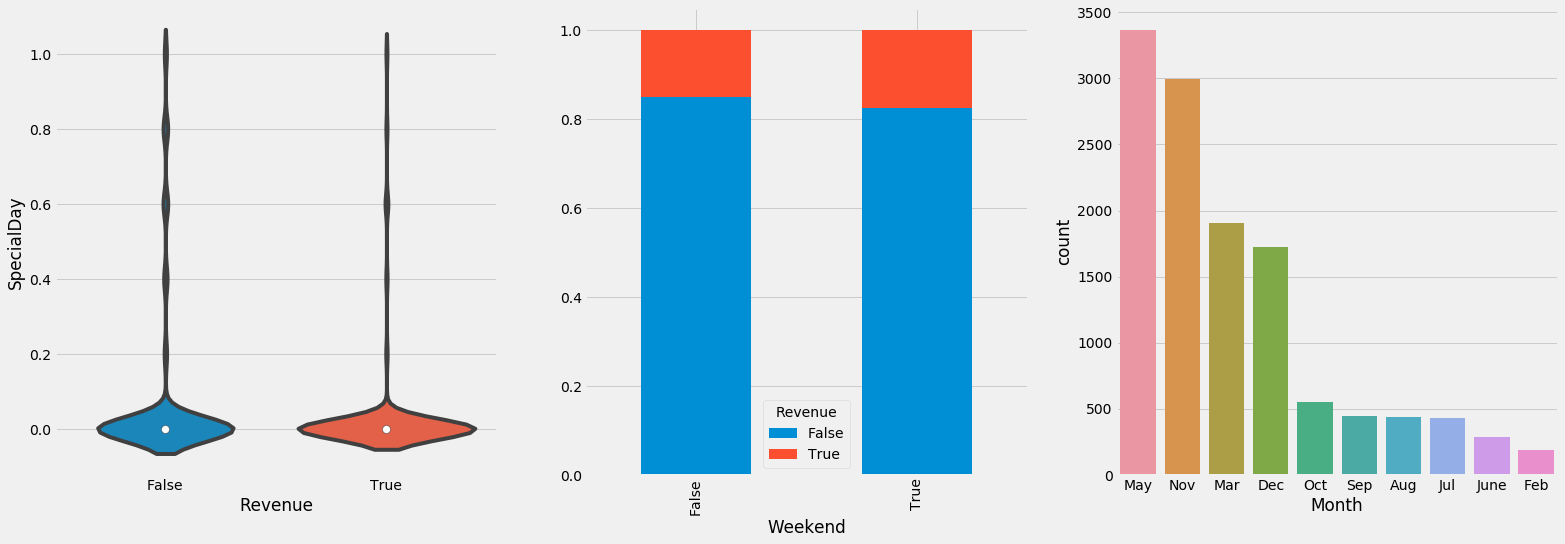

In [55]:
fig, axs = plt.subplots(1,3,figsize=(24,8))
sns.violinplot(y= 'SpecialDay',x= 'Revenue',ax=axs[0],data=df_shopping_data)

table=pd.crosstab(df_shopping_data.Weekend,df_shopping_data['Revenue'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax=axs[1])


monthly = df_shopping_data['Month'].value_counts()

sns.countplot(df_shopping_data['Month'], order=monthly.index,ax=axs[2])


### Explore Visitor attributes
- VisitorType:
- TrafficType: Type of traffic the user is categorized into. (i.e seo,direct etc) will be treated as a categorical feature
- Region: We will assume that the current exercise is not focusing on region

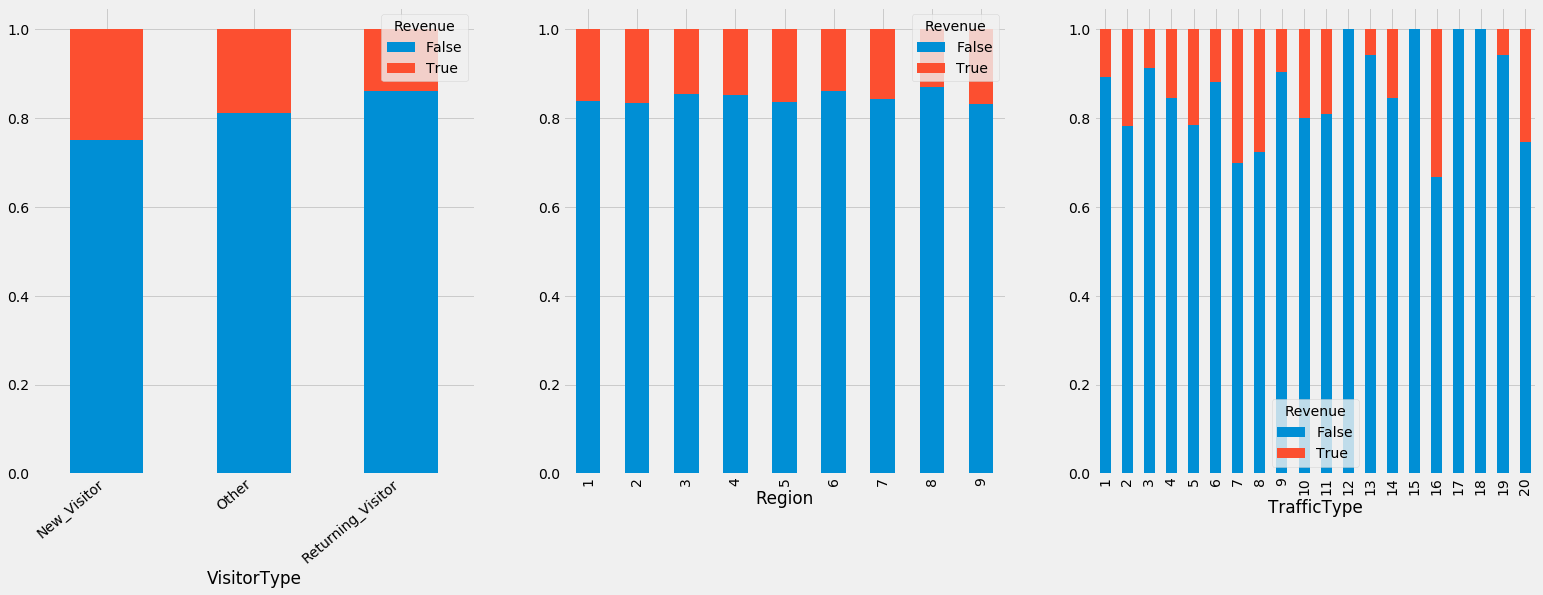

In [56]:
fig, axs = plt.subplots(1,3,figsize=(24,8))
table=pd.crosstab(df_shopping_data.VisitorType,df_shopping_data['Revenue'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=40, ha="right")
table=pd.crosstab(df_shopping_data.Region,df_shopping_data['Revenue'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax=axs[1])

table=pd.crosstab(df_shopping_data.TrafficType,df_shopping_data['Revenue'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax=axs[2])

## Drop following features
- OperatingSystems           
- Browser       
**We dont have much control over it. Large number of users are using a particular type of Browser or OS**

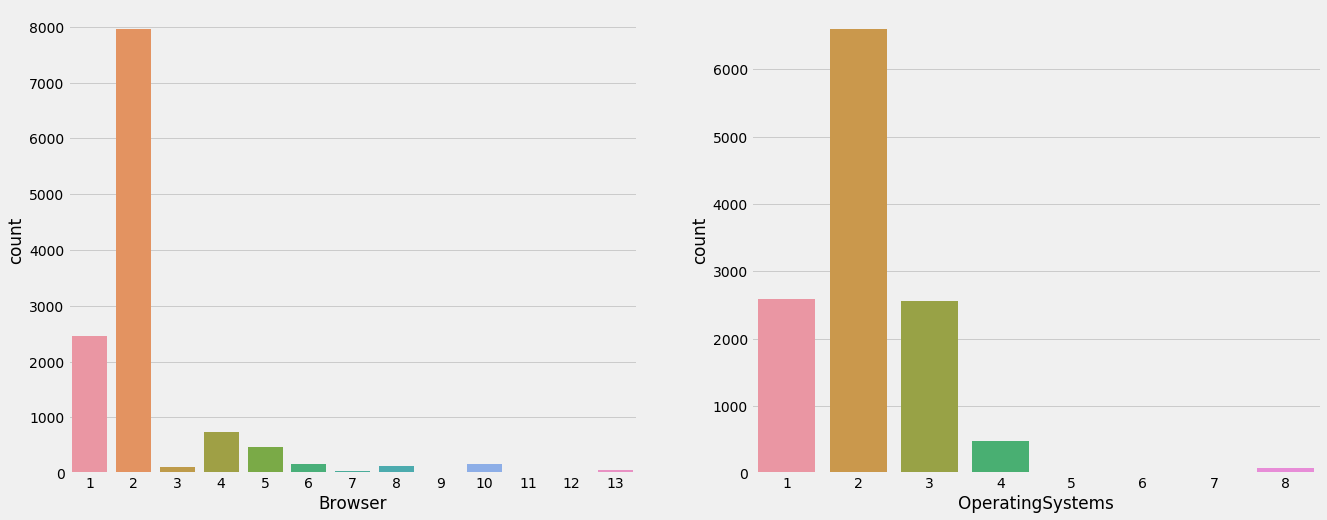

In [57]:
fig, axs = plt.subplots(1,2,figsize=(20,8))
sns.countplot(df_shopping_data['Browser'],ax=axs[0])
sns.countplot(df_shopping_data['OperatingSystems'],ax=axs[1])

## Feature Engineering
We will be using the following features
- Web session related features
    1. Administrative
    2. Administrative_Duration
    3. Informational
    4. Informational_Duration
    5. ProductRelated
    6. ProductRelated_Duration
- Digital metrics
    7. BounceRates
    8. ExitRates
- Time related features
    9. SpecialDay
    10. Weekend (Categorical--> Label Encode it)
-  Visitor attributes
    11. VisitorType (Categorical)
    12. TrafficType (Categorical)
    
Drop the following features
1. Month
2. Browser
3. OperatingSystems
4. Region

In [63]:


df_feature_engineer = df_shopping_data.drop(['Month','Browser','OperatingSystems','Region'], axis=1).copy()

# label encode Weekend
df_feature_engineer['Weekend'] = df_feature_engineer.Weekend.astype(int)

# one hot encode VisitorType
visitor_encoded = pd.get_dummies(df_feature_engineer['VisitorType'], prefix='Visitor_Type')
df_feature_engineer = pd.concat([df_feature_engineer, visitor_encoded], axis=1).drop(['VisitorType'], axis=1)

# one hot encode TrafficType
TrafficType_encoded = pd.get_dummies(df_feature_engineer['TrafficType'], prefix='TrafficType')
df_feature_engineer = pd.concat([df_feature_engineer, TrafficType_encoded], axis=1).drop(['TrafficType'], axis=1)

df_feature_engineer.shape

(12330, 35)

## Model Building
### Split Data into Test/Train (80/20)

In [64]:
X = df_feature_engineer.drop('Revenue', axis=1)
y = df_feature_engineer['Revenue']
X_train_stratified, X_test_stratified, y_train_stratified, y_test_stratified = train_test_split(X, y,stratify=y, test_size=.2, random_state=2)
print('Number of training samples :',X_train_stratified.shape[0])
print('Number of test samples :',X_test_stratified.shape[0])

Number of training samples : 9864
Number of test samples : 2466


In [60]:
# precision = 'precision'

# numeric_features = ['Administrative','Informational_normalized','ProductRelated_normalized','BounceRates','ExitRates','SpecialDay']

# numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)],remainder='passthrough')

# pipe_logistic = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', LogisticRegression(random_state=1))])

# param_grid = [
#     {
#      'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-4, 4, 20),
#     'classifier__solver' : ['liblinear']}]
# gs_cv = GridSearchCV(estimator=pipe_logistic, param_grid=param_grid,scoring= 'precision',cv=5,n_jobs=-1,verbose=1)

# gs_cv = gs.fit(X_train_stratified, y_train_stratified)

# y_pred_stratified = gs_cv.predict(X_test_stratified)
# y_pred_stratified_prob = gs_cv.predict_proba(X_test_stratified)
# classifier_precision, classifier_recall, _ = precision_recall_curve(y_test_stratified, y_pred_stratified_prob[:, 1])

# print('Optimizing on ',_scoring)
# print('best model scores',gs_cv.best_score_)
# print('best model parameters',gs_cv.best_params_)
# print('ROC AUC score',roc_auc_score(y_test_stratified, y_pred_stratified_prob[:, 1]))
# print('PR AUC Curve',auc(classifier_recall, classifier_precision))
# print("accuracy:", accuracy_score(y_test_stratified, y_pred_stratified))


Optimizing on  f1
best model scores 0.16208051066118556
best model parameters {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
ROC AUC score 0.7151797288741948
PR AUC Curve 0.2659162242189317
accuracy: 0.8260340632603407


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [61]:
# _scoring = 'f1'
# pipe_rf = Pipeline([('classifier' , RandomForestClassifier(random_state=1))])
# param_grid = [
#     {
#     'classifier__n_estimators' : list(range(10,101,10)),
#     'classifier__max_depth' : list(range(20,30,2))}
# ]
# gs_cv = GridSearchCV(estimator=pipe_logistic, param_grid=param_grid,scoring= 'f1',cv=5,n_jobs=-1,verbose=1)

# gs_cv = gs.fit(X_train_stratified, y_train_stratified)

# y_pred_stratified = gs_cv.predict(X_test_stratified)
# y_pred_stratified_prob = gs_cv.predict_proba(X_test_stratified)
# classifier_precision, classifier_recall, _ = precision_recall_curve(y_test_stratified, y_pred_stratified_prob[:, 1])

# print('Optimizing on ',_scoring)
# print('best model scores',gs_cv.best_score_)
# print('best model parameters',gs_cv.best_params_)
# print('ROC AUC score',roc_auc_score(y_test_stratified, y_pred_stratified_prob[:, 1]))
# print('PR AUC Curve',auc(classifier_recall, classifier_precision))
# print("accuracy:", accuracy_score(y_test_stratified, y_pred_stratified))

Optimizing on  f1
best model scores 0.16208051066118556
best model parameters {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
ROC AUC score 0.7151797288741948
PR AUC Curve 0.2659162242189317
accuracy: 0.8260340632603407


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   11.5s finished
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be ava

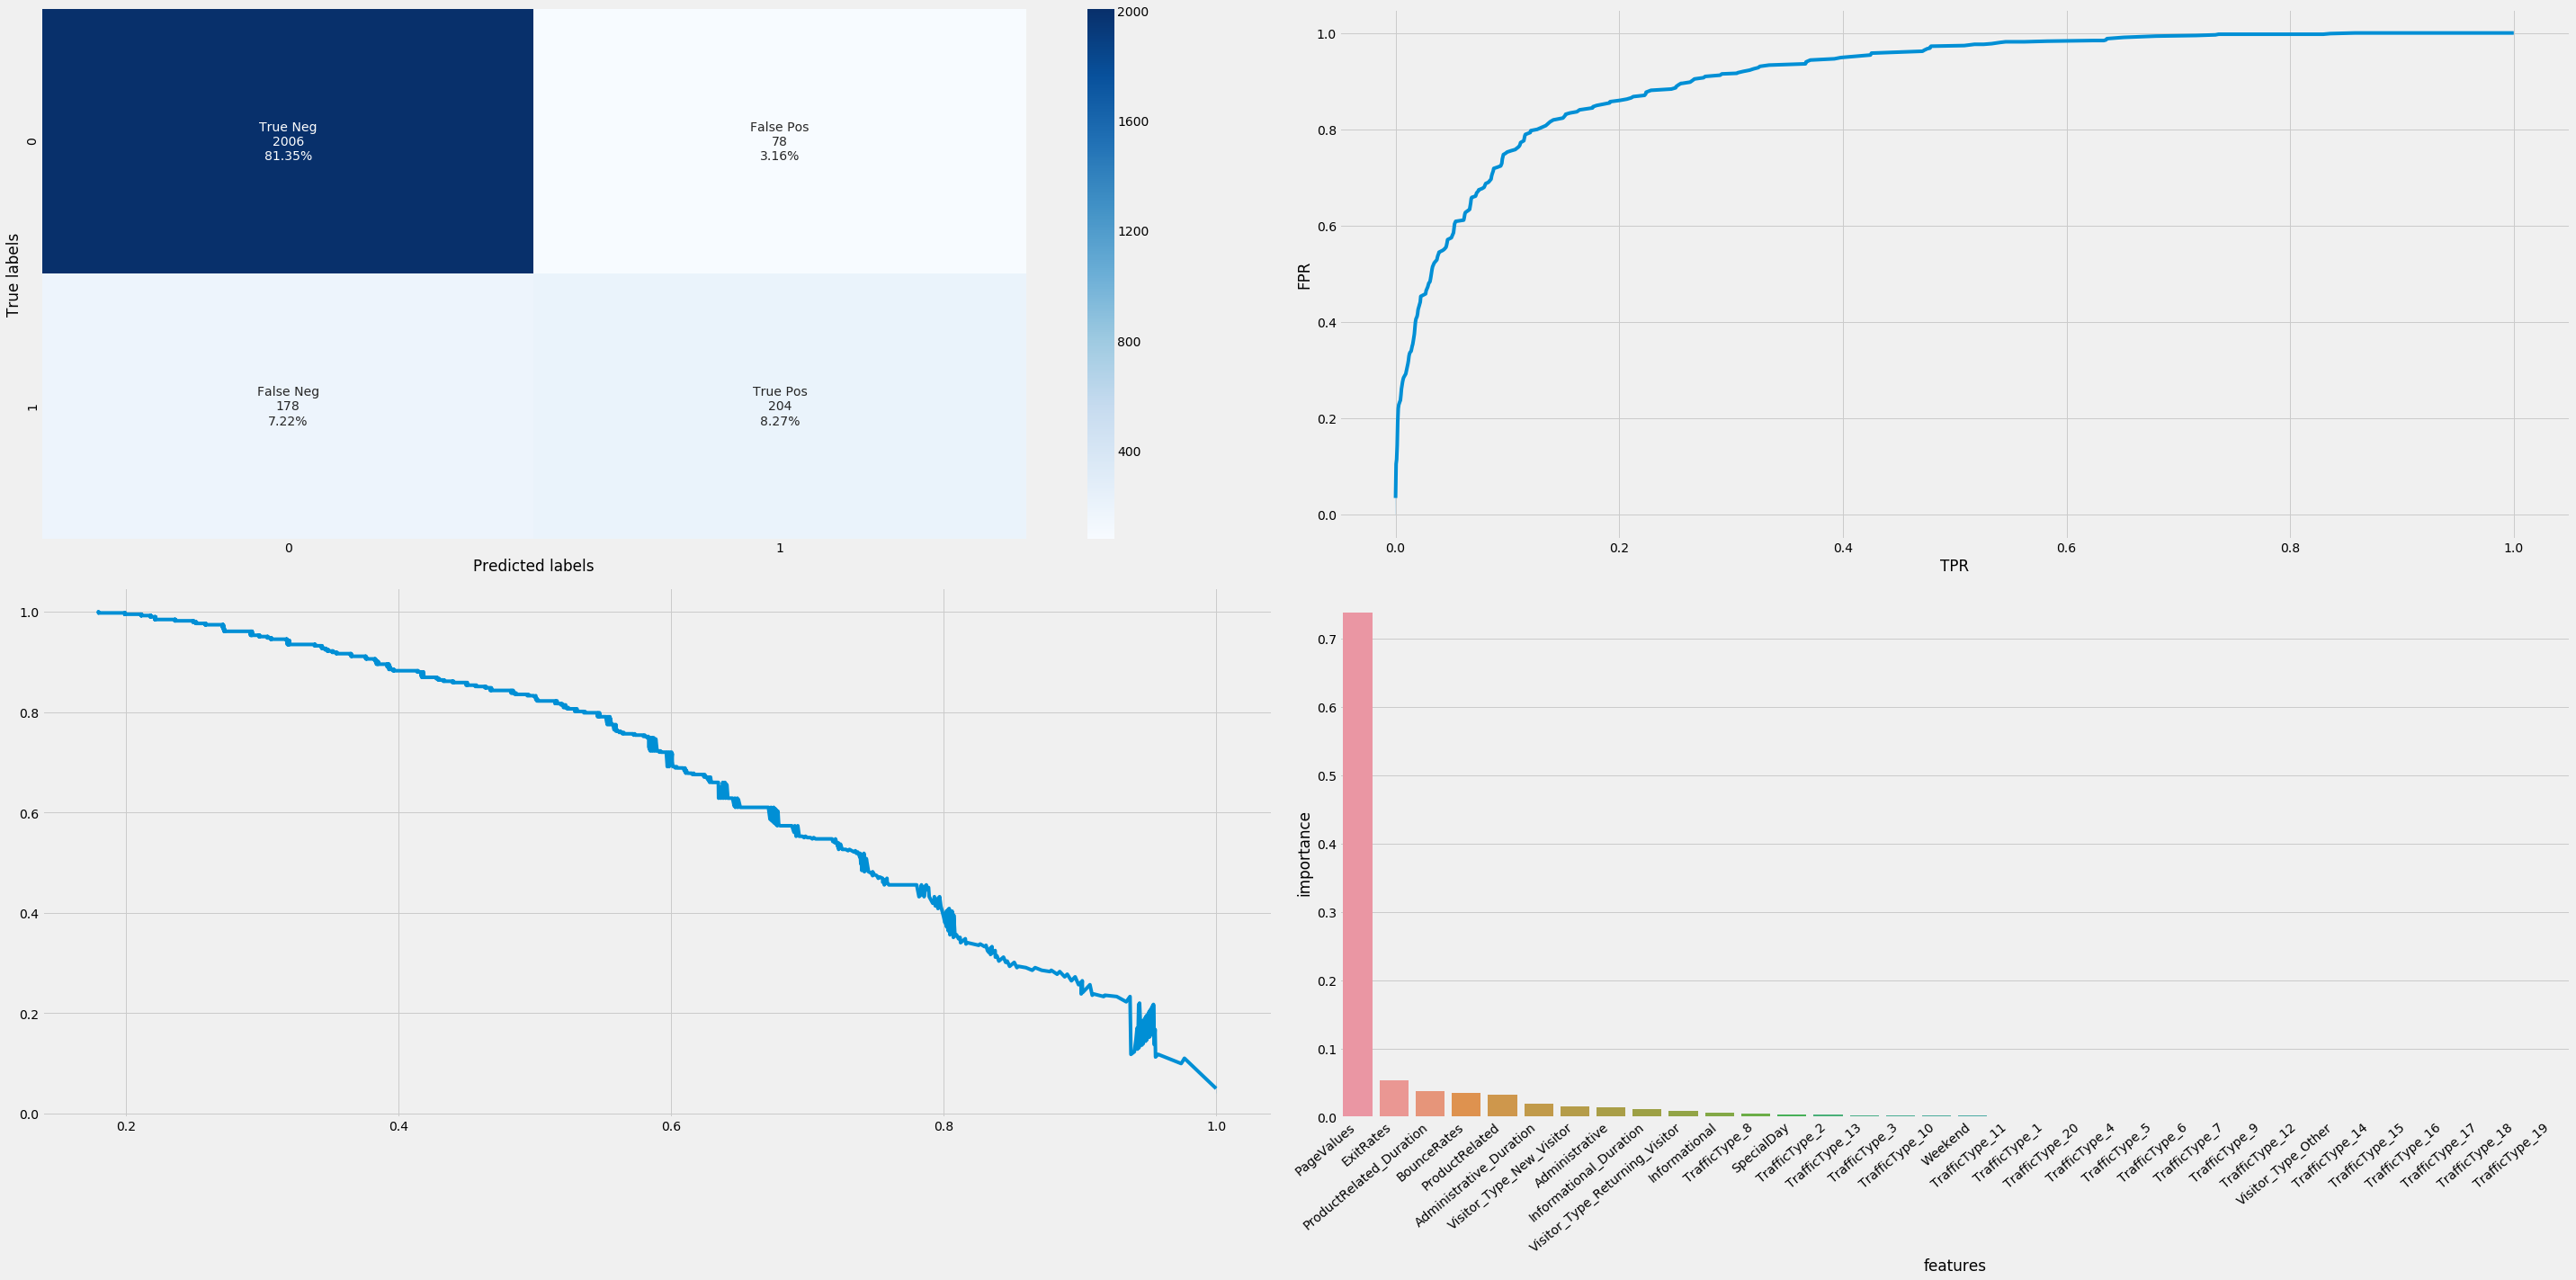

Optimizing on  f1
best model scores 0.6370209697450167
best model parameters {'classifier__max_depth': 7, 'classifier__min_samples_split': 800}
ROC AUC score 0.911793042980173
PR AUC Curve 0.7124008595692203
accuracy: 0.8961881589618816


In [66]:

for _scoring in ['f1']:
    
    pipe_GBM = Pipeline([('classifier' , GradientBoostingClassifier(random_state=1,learning_rate=0.1,
                                                                min_samples_leaf=50,max_depth=8,max_features='sqrt'
                                                                ,subsample=0.8,n_estimators = 70))])
    param_grid_dept_samples_split = [ {'classifier__max_depth':range(5,16,2), 'classifier__min_samples_split':range(200,1001,200)}]
    gs_cv = GridSearchCV(estimator=pipe_GBM, param_grid=param_grid_dept_samples_split,scoring=_scoring,cv=5,n_jobs=-1,verbose=1)
    gs_cv.fit(X_train_stratified, y_train_stratified)

    y_pred_stratified = gs_cv.predict(X_test_stratified)
    y_pred_stratified_prob = gs_cv.predict_proba(X_test_stratified)

    df_model_scores = pd.DataFrame(gs_cv.cv_results_)
    
    fig, axs = plt.subplots(2,2,figsize=(40,20))

    cf_matrix = confusion_matrix(y_test_stratified, y_pred_stratified)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',ax=axs[0,0])
    axs[0,0].set_xlabel('Predicted labels');axs[0,0].set_ylabel('True labels'); 

    classifier_fpr, classifier_tpr, _ = roc_curve(y_test_stratified, y_pred_stratified_prob[:, 1])
    sns.lineplot(classifier_fpr,classifier_tpr,ax=axs[0,1] )
    axs[0,1].set_xlabel('TPR');axs[0,1].set_ylabel('FPR'); 
    #print('ROC AUC score',roc_auc_score(y_test_stratified, y_pred_stratified_prob[:, 1]))


    classifier_precision, classifier_recall, _ = precision_recall_curve(y_test_stratified, y_pred_stratified_prob[:, 1])
    sns.lineplot(classifier_precision,classifier_recall,ax=axs[1,0])
    #print('PR AUC Curve',auc(classifier_recall, classifier_precision))




    df_feature_importance = pd.DataFrame({'features':X_train_stratified.columns,'importance':gs_cv.best_estimator_.steps[0][1].feature_importances_})
    df_feature_importance.sort_values(by =['importance'],inplace=True,ascending =False)
    sns.barplot(x= 'features', y = 'importance', data=df_feature_importance,ax=axs[1,1])
    axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()
    
    
    print('Optimizing on ',_scoring)
    print('best model scores',gs_cv.best_score_)
    print('best model parameters',gs_cv.best_params_)
    print('ROC AUC score',roc_auc_score(y_test_stratified, y_pred_stratified_prob[:, 1]))
    print('PR AUC Curve',auc(classifier_recall, classifier_precision))
    print("accuracy:", accuracy_score(y_test_stratified, y_pred_stratified))
    
    

